In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from isochrones import get_ichrone
from sbi import analysis
import corner
import pandas as pd
#from sbi.utils import process_prior
from sbi import utils
from sbi.inference import SNPE as method

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Define simulator

In [3]:
tracks = get_ichrone('mist', tracks=True)

# def binary_color_mag_isochrones(m1, q, age, fe_h, log_dist):
#     # isochrones.py needs log10(Age [yr]). 
#     # Our age is in Gyr, so we take log10(age * 10^9) = log10(age) + 9
#     dist = np.float64(10**log_dist)
#     properties = tracks.generate_binary(m1, q * m1, np.log10(age) + 9, fe_h, distance=dist, bands=["G", "BP", "RP"])
    
#     # #g_mag = properties.G_mag.values[0]
#     # bp_mag = properties.BP_mag.values[0]
#     # rp_mag = properties.RP_mag.values[0]
#     # #dist = np.array(dist)
#     g_mag = properties.G_mag.values - 5* np.log10(dist) + 5

#     #g_mag = properties.G_mag.values 
#     bp_mag = properties.BP_mag.values
#     rp_mag = properties.RP_mag.values
    
#     return np.array([g_mag, bp_mag, rp_mag]).T

def binary_color_mag_isochrones(m1, q, age, fe_h):
    properties = tracks.generate_binary(m1, q * m1, np.log10(age) + 9, fe_h, bands=["G", "BP", "RP"])
    g_mag = properties.G_mag.values 
    bp_mag = properties.BP_mag.values
    rp_mag = properties.RP_mag.values
    return np.array([g_mag, bp_mag, rp_mag]).T

def simulator(theta):
    return torch.tensor(binary_color_mag_isochrones(*theta))

In [ ]:
# class StellarPrior:

#     def __init__(
#         self, 
#         M1_bounds=(0.3, 5.0),   
#         q_bounds=(0.0, 1.0),    
#         tau_bounds=(age_lower, age_upper), 
#         m_h_bounds=(fe_h_lower, fe_h_upper), 
#         distance_bounds=(100.0, 1000.0), 
#         M1_alpha=1.0,
#         M1_beta=5.0,
#         m_h_alpha=10.0,
#         m_h_beta=2.0,
#         m_h_scale=3.0,
#         return_numpy=False
#     ):
#         self.bounds = dict(
#             lower_bound=tt([M1_bounds[0], q_bounds[0], tau_bounds[0], m_h_bounds[0], distance_bounds[0]]),
#             upper_bound=tt([M1_bounds[1], q_bounds[1], tau_bounds[1], m_h_bounds[1], distance_bounds[1]])
#         )
#         self.lower = tt([M1_alpha, 1.0, 1.0, m_h_alpha, 1.0])
#         self.upper = tt([M1_beta, 1.0, 1.0, m_h_beta, 1.0])
#         m_h_mode = (m_h_alpha - 1)/(m_h_alpha + m_h_beta - 2)
#         loc = tt([M1_bounds[0], q_bounds[0], tau_bounds[0], -m_h_mode * m_h_scale, distance_bounds[0]])
#         scale = tt([M1_bounds[1], q_bounds[1], tau_bounds[1], m_h_scale, distance_bounds[1]])
#         self.return_numpy = return_numpy
#         self.dist = Independent(TransformedDistribution(Beta(self.lower, self.upper, validate_args=False), AffineTransform(loc=loc, scale=scale)), 1)

#     def sample(self, sample_shape=torch.Size([])):
#         samples = self.dist.sample(sample_shape)
#         return samples.numpy() if self.return_numpy else samples

#     def log_prob(self, values):
#         if self.return_numpy:
#             values = torch.as_tensor(values)
#         log_probs = self.dist.log_prob(values)
#         return log_probs.numpy() if self.return_numpy else log_probs


#import sbi.utils.user_input_checks 
#print(dir(sbi.utils.user_input_checks ))

# custom_prior = StellarPrior()
# prior, *_ = process_prior(custom_prior, custom_prior_wrapper_kwargs=custom_prior.bounds)

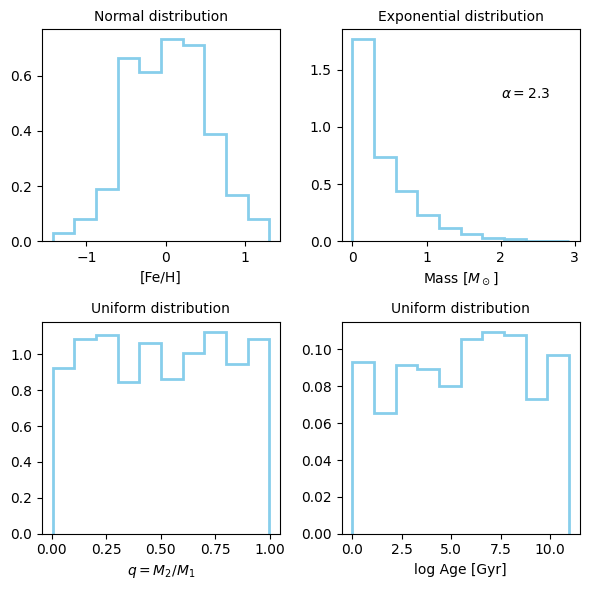

In [4]:
import matplotlib.pyplot as plt
from torch.distributions import Uniform, Normal, Exponential

n_sample = 500

fig, ax = plt.subplots(2, 2, figsize=(6, 6))

#normal_distribution = Normal(loc=0.06, scale=0.1)
normal_distribution = Normal(loc=0.0, scale=0.5)
ax[0,0].hist(normal_distribution.sample((n_sample,)), histtype='step', lw=2, density=True, color='skyblue')
ax[0,0].set_xlabel(r'[Fe/H]')
ax[0,0].set_title('Normal distribution', fontsize=10)
# ax[0,0].text(0.18,3, r'$\mu=0.06$')
# ax[0,0].text(0.18,2.5, r'$\sigma=0.1$')

exponential_distribution = Exponential(rate=2.3)
ax[0,1].hist(exponential_distribution.sample((n_sample,)), histtype='step', lw=2, density=True, color='skyblue')
ax[0,1].set_xlabel(r'Mass [$M_\odot$]')
ax[0,1].set_title('Exponential distribution', fontsize=10)
ax[0,1].text(2, 1.25, r'$\alpha=2.3$')

uniform_distribution_on_q = Uniform(low=0.0, high=1.0)
ax[1,0].hist(uniform_distribution_on_q.sample((n_sample,)), histtype='step', lw=2, density=True, color='skyblue')
ax[1,0].set_xlabel(r'$q=M_2 / M_1$')
ax[1,0].set_title('Uniform distribution', fontsize=10)

uniform_distribution_on_age = Uniform(low=0.01, high=11.0)
ax[1,1].hist(uniform_distribution_on_age.sample((n_sample,)), histtype='step', lw=2, density=True, color='skyblue')
ax[1,1].set_xlabel('log Age [Gyr]')
ax[1,1].set_title('Uniform distribution', fontsize=10)

fig.tight_layout()
plt.show()

# Set priors

In [5]:
from torch.distributions import (Uniform, Normal, Exponential, Beta, Pareto)
from torch.distributions.transforms import AffineTransform
from torch.distributions.transformed_distribution import TransformedDistribution

from torch import tensor as tt

#from sbi.inference import simulate_for_sbi
from sbi.utils.user_input_checks import prepare_for_sbi


age_bounds = [0.2, 10.0]          # Gyr
mass_bounds = [0.3, 3.0]          # M1
metallicity_bounds = [-1.5, 0.5]  # [Fe/H] forced metallicity distribution

num_simulations = 50_000
num_samples = 10_000

# prior = [
#     TransformedDistribution(Exponential(rate=tt([2.3])), \
#                             AffineTransform(loc=tt([mass_bounds[0]]), scale=tt([mass_bounds[1]]))),                   # M1
#     Uniform(tt([0.]), tt([1.])),                                                                                      # q
#     Uniform(tt([age_bounds[0]]), tt([age_bounds[1]])),                                                                # age
#     TransformedDistribution(Normal(loc=tt([0.0]), scale=tt([0.5])), \
#                             AffineTransform(loc=tt([metallicity_bounds[0]]), scale=tt([metallicity_bounds[1]])))      # [Fe/H]
#     ]

# prior = [
#         TransformedDistribution(Pareto(scale=tt([1.]), alpha=tt([5.])), AffineTransform(loc=tt([0.8]), scale=tt([1.]))), # M1
#         Uniform(tt([0.]), tt([1.])),                                                                                     # q
#         Uniform(tt([1.]), tt([10.])),                                                                                    # age
#         TransformedDistribution(Beta(tt([10.]), tt([2.])), AffineTransform(loc=tt([-1.5]), scale=tt([0.5])))             # [Fe/H]
#         ]

bounds = np.array([
    [mass_bounds[0],  mass_bounds[1]],                           # M1
    [0,      1],                                                 # q
    [age_bounds[0],   age_bounds[1]],                            # (Gyr)
    [metallicity_bounds[0], metallicity_bounds[1]]               # metallicity
    ])
bounds = torch.tensor(bounds)
prior = utils.BoxUniform(low=bounds.T[0], high=bounds.T[1])

# Generate the simulations. 
## Run if a new posterior is required
### We do this ourselves (instead of using simulate_for_sbi) because if we don't then many will be NaNs and we end up with fewer simulations than we want.

In [17]:
# def simulate_for_sbi_strict(simulator, proposal, num_simulations, max_trials=np.inf):
#     num_trials, num_simulated, theta, x = (0, 0, [], [])
    
#     while num_simulated < num_simulations:
#         N = num_simulations - num_simulated
#         print(f"Running {N} simulations")
#         _theta = proposal.sample((N, ))
#         _x = simulator(_theta)
#         _x = _x.squeeze(1)  # This will change it from [1, 1, 3] to [1, 3]
#         #_theta, _x = simulate_for_sbi(simulator, proposal=proposal, num_simulations=N)
#         keep = np.all(np.isfinite(_x).numpy(), axis=1)
        
#         theta.extend(np.array(_theta[keep]))
#         x.extend(np.array(_x[keep]))

#         num_trials += 1
#         num_simulated += sum(keep)
#         if num_trials > max_trials:
#             print(f"Warning: exceeding max trials ({max_trials}) with {num_simulated} / {num_simulations} simulations")
#             break
#     theta = torch.tensor(np.vstack(theta))
#     x = torch.tensor(np.vstack(x))
#     return (theta, x)


# posterior_path = "./data/train_posterior.pkl"

# if os.path.exists(posterior_path):
#     print(f"Pre-loading posterior from {posterior_path}")
#     with open(posterior_path, "rb") as fp:
#         posterior, (theta, x) = pickle.load(fp)

# else:
#     theta, x = simulate_for_sbi_strict(sbi_simulator, sbi_prior, num_simulations)
#     density_estimator = inference.append_simulations(theta, x).train()
#     posterior = inference.build_posterior(density_estimator) # mcmc_method='slice_np' sample_with='vi', vi_method='rKL'
    
#     with open(posterior_path, "wb") as fp:
#         pickle.dump((posterior, (theta, x)), fp)
        
#     print(f"Saved posterior to {posterior_path}")

# Build or load posterior

In [6]:
# Generate the simulations. 
# We do this ourselves (instead of using simulate_for_sbi) because if we don't then many will be NaNs
# and we end up with fewer simulations than we want.

posterior_path = "./data/train_posterior_uniform.pkl"

def simulate_for_sbi_strict(simulator, proposal, num_simulations, max_trials=np.inf):
    num_trials, num_simulated, theta, x = (0, 0, [], [])
    while num_simulated < num_simulations:
        N = num_simulations - num_simulated
        print(f"Running {N} simulations")
        _theta = proposal.sample((N, ))
        _x = simulator(_theta)
        _x = _x.squeeze(1) # This will change it from [50000, 1, 3] to [50000, 3]
        #_theta, _x = simulate_for_sbi(simulator, proposal=proposal, num_simulations=N)
        keep = np.all(np.isfinite(_x).numpy(), axis=1)
        theta.extend(np.array(_theta[keep]))
        x.extend(np.array(_x[keep]))
        num_trials += 1
        num_simulated += sum(keep)
        if num_trials > max_trials:
            print(f"Warning: exceeding max trials ({max_trials}) with {num_simulated} / {num_simulations} simulations")
            break
    theta = torch.tensor(np.vstack(theta))
    x = torch.tensor(np.vstack(x))
    return (theta, x)

if os.path.exists(posterior_path):
    print(f"Pre-loading posterior from {posterior_path}")
    with open(posterior_path, "rb") as fp:
        posterior, (theta, x) = pickle.load(fp)

else:
    theta, x = simulate_for_sbi_strict(sbi_simulator, sbi_prior, num_simulations)
    density_estimator = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(density_estimator, sample_with='mcmc')
    
    with open(posterior_path, "wb") as fp:
        pickle.dump((posterior, (theta, x)), fp)
        
    print(f"Saved posterior to {posterior_path}")

Pre-loading posterior from ./data/train_posterior_uniform.pkl


In [7]:
x.shape, theta.shape

(torch.Size([50000, 3]), torch.Size([50000, 4]))

In [ ]:
# mask = (x[:, 0] >= 1.) & (x[:, 0] <= 10.)
# x = x[mask]
# theta = theta[mask]
# x.shape, theta.shape

In [ ]:
#['par','b','g','r','j','h','k','w1','w2']
# g, bp, rp, dist

In [8]:
#x = x[:,0:4]
x

tensor([[8.6583, 9.8887, 7.6000],
        [2.3768, 2.4191, 2.2890],
        [0.1463, 0.1040, 0.2062],
        ...,
        [6.3420, 6.8006, 5.7198],
        [5.2836, 5.6216, 4.7738],
        [4.9130, 5.1957, 4.4541]])

In [9]:
# m1, q, age, fe_h
theta

tensor([[ 0.5384,  0.7574,  3.8484,  0.3530],
        [ 1.2340,  0.7076,  2.0781, -1.4987],
        [ 2.4837,  0.1195,  0.4002, -0.9672],
        ...,
        [ 0.6399,  0.6891,  3.0656, -0.9089],
        [ 0.7952,  0.4040,  7.6429, -0.3873],
        [ 0.7938,  0.7452,  4.0752, -1.0583]])

In [10]:
min_g_mag_simulated = x[:,0].numpy().min()
max_g_mag_simulated = x[:,0].numpy().max()
min_bp_mag_simulated = x[:,1].numpy().min()
max_bp_mag_simulated = x[:,1].numpy().max()
min_rp_mag_simulated = x[:,2].numpy().min()
max_rp_mag_simulated = x[:,2].numpy().max()

print(f'g_mag ranges from {min_g_mag_simulated} to {max_g_mag_simulated}')
print(f'bp_mag ranges from {min_bp_mag_simulated} to {max_bp_mag_simulated}')
print(f'rp_mag ranges from {min_rp_mag_simulated} to {max_rp_mag_simulated}')

g_mag ranges from -5.208145618438721 to 12.169828414916992
bp_mag ranges from -5.123373985290527 to 14.633679389953613
rp_mag ranges from -5.3502326011657715 to 10.855380058288574


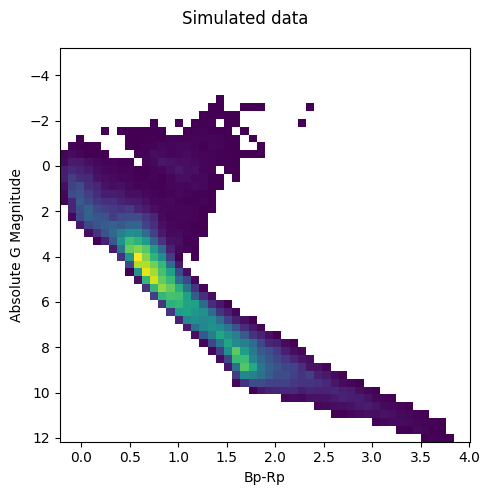

In [11]:
# g_mag, bp_mag, rp_mag in aboslute magnitude
g_mag = x.numpy()[:,0]
color_mag = x.numpy()[:,1] - x.numpy()[:,2]

fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Simulated data')
ax.hist2d(color_mag, g_mag, bins=50, density=False, cmin=2)
ax.set_xlabel('Bp-Rp')
ax.set_ylabel('Absolute G Magnitude')
ax.invert_yaxis()
fig.tight_layout()

# Test for one star

In [12]:
posterior

MCMCPosterior sampler for potential_fn=<LikelihoodBasedPotential>

[1.8  0.7  1.   0.01]
tensor([[1.5559, 1.6893, 1.3148]], dtype=torch.float64)


Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

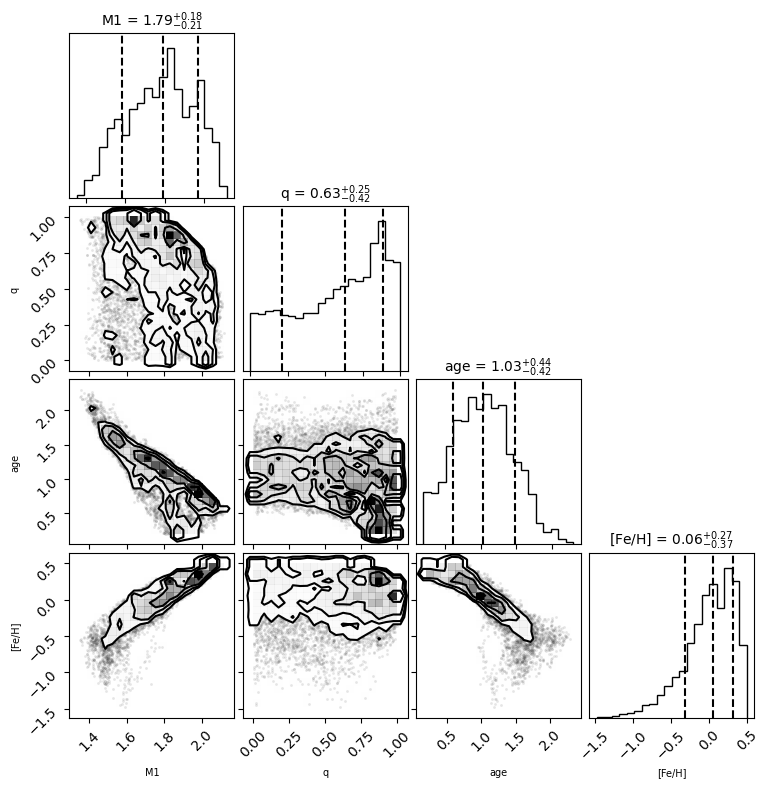

In [13]:
mass = 1.8
q = 0.7
age = 1.0
metallicity = 0.01


truth = np.array([mass, q, age, metallicity]) # np.log10(dist)
print(truth)
observation = simulator(truth)
print(observation)
assert np.all(np.isfinite(np.array(observation)))

samples = posterior.sample((num_samples,), x=torch.tensor(observation), show_progress_bars=True) # sample_with='mcmc'

labels = ("M1", "q", "age", "[Fe/H]") #  "dist"

n_dim = samples.numpy().shape[1]
fig, _ = plt.subplots(n_dim, n_dim, figsize=(8,8))
fig = corner.corner(samples.numpy(), labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, fig=fig,
                    title_kwargs={"fontsize":10}, label_kwargs=dict(fontsize=7), truth_color='C0')
# truths=truth

# Read data from star cluster

1090


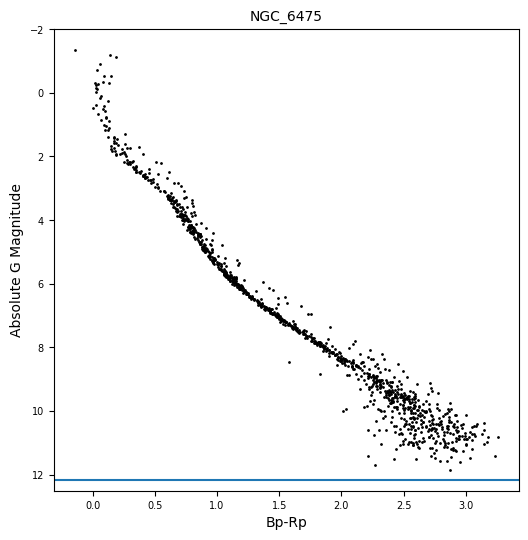

In [14]:
data = pd.read_csv('./data/members_dat.csv')

cluster = 'NGC_6475' #'NGC_6475'
remove_stars = pd.read_csv('./data/SGs_and_RGBs_clusters_sourceid.csv')
list_remove_stars = remove_stars['source_id'][(remove_stars['cluster'] == cluster)].to_list()

df_cluster = data[data['cluster'] == cluster]
df_cluster = df_cluster[~df_cluster['source_id'].isin(list_remove_stars)]

df_cluster['g_mag'] = df_cluster['phot_g_mean_mag'] - 5* np.log10(1000/df_cluster['parallax']) + 5
df_cluster['bp_mag'] = df_cluster['phot_bp_mean_mag'] - 5* np.log10(1000/df_cluster['parallax']) + 5
df_cluster['rp_mag'] = df_cluster['phot_rp_mean_mag'] - 5* np.log10(1000/df_cluster['parallax']) + 5

print(len(df_cluster))

fig, ax = plt.subplots(figsize=(6,6))
ax.set_title(cluster, fontsize=10)
ax.scatter(df_cluster['bp_mag'] - df_cluster['rp_mag'], df_cluster['g_mag'], s=1, marker='o', c='k')
ax.axhline(max_g_mag_simulated)
ax.invert_yaxis()
ax.set_xlabel('Bp-Rp')
ax.set_ylabel('Absolute G Magnitude')
ax.tick_params(axis='both', which='major', labelsize=7)

In [15]:
print('df g ranges: ', df_cluster['g_mag'].min(), df_cluster['g_mag'].max())
print('df bp ranges: ', df_cluster['bp_mag'].min(), df_cluster['bp_mag'].max())
print('df rp ranges: ', df_cluster['rp_mag'].min(), df_cluster['rp_mag'].max())

df g ranges:  -1.3546633337565437 11.84605627183893
df bp ranges:  -1.4205723337565441 13.43411965455219
df rp ranges:  -1.285989423533798 10.550806271838931


In [16]:
cond_g = (df_cluster['g_mag'] >= min_g_mag_simulated) & (df_cluster['g_mag'] <= max_g_mag_simulated)
cond_bp = (df_cluster['bp_mag'] >= min_bp_mag_simulated) & (df_cluster['bp_mag'] <= max_bp_mag_simulated)
cond_rp = (df_cluster['rp_mag'] >= min_rp_mag_simulated) & (df_cluster['rp_mag'] <= max_rp_mag_simulated)

bound_df_cluster = df_cluster[cond_g & cond_bp & cond_rp].reset_index(drop=True)
bound_df_cluster

,source_id,ra,dec,pmra,pmdec,parallax,parallax_corrected,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,cluster,g_mag,bp_mag,rp_mag
0,4039931725653660544,268.282551,-37.110006,3.140380,-5.833935,3.651388,3.617150,13.004601,13.477786,12.371492,NGC_6475,5.816891,6.290076,5.183782
1,4039018512529423360,270.692256,-35.161469,3.545403,-5.120698,3.575582,3.575582,17.964058,19.245052,16.654226,NGC_6475,10.730792,12.011786,9.420960
2,4039009789556712832,270.615784,-35.403758,3.247486,-5.160776,3.469499,3.437812,10.855417,11.159005,10.354898,NGC_6475,3.556751,3.860339,3.056232
3,4039012430851778688,270.453771,-35.336052,3.955242,-6.074262,3.673141,3.629934,13.371992,13.901957,12.675690,NGC_6475,6.197180,6.727145,5.500878
4,4040793811722135808,268.455633,-35.071979,2.798568,-4.792476,3.531545,3.531545,18.445030,19.451120,17.014086,NGC_6475,11.184853,12.190943,9.753909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,4043388457118235136,267.896704,-33.452152,3.468674,-5.533250,3.592259,3.561883,10.385437,10.622767,9.989314,NGC_6475,3.162275,3.399605,2.766152
1086,4043392816513324928,267.780259,-33.369144,2.155390,-5.116212,3.629188,3.568023,16.826498,18.205390,15.636375,NGC_6475,9.625545,11.004437,8.435422
1087,4043357258503604352,269.208472,-32.688905,2.944836,-5.009764,3.651980,3.614024,6.649078,6.684957,6.534089,NGC_6475,-0.538280,-0.502401,-0.653269
1088,4043399761419023872,268.226090,-33.153245,2.366334,-5.293691,3.621000,3.573355,18.157236,19.878290,16.957027,NGC_6475,10.951378,12.672432,9.751169


In [ ]:
L = 4 # number of parameters
num_injections = len(bound_df_cluster)
parameters = np.empty((num_injections, num_samples, L))
# g_mag, bp_mag, rp_mag

for i in tqdm(range(num_injections)):
    observation_per_star = bound_df_cluster[['g_mag','bp_mag','rp_mag']].to_numpy()[i]
    #print(observation_per_star)
    parameters[i] = posterior.sample((num_samples,), x=torch.tensor(observation_per_star), show_progress_bars=False)
    #break

In [28]:
parameters[0]

array([[ 0.69674349,  0.79648113,  9.33727551, -0.38198808],
       [ 0.69656211,  0.79299694,  9.41978073, -0.3921372 ],
       [ 0.69648582,  0.7924999 ,  9.28683376, -0.41727078],
       ...,
       [ 0.59461099,  0.99935776,  3.06526899, -1.67714167],
       [ 0.59380537,  0.99905366,  3.42538476, -1.67774224],
       [ 0.59403086,  0.99907267,  3.49504328, -1.67813015]])

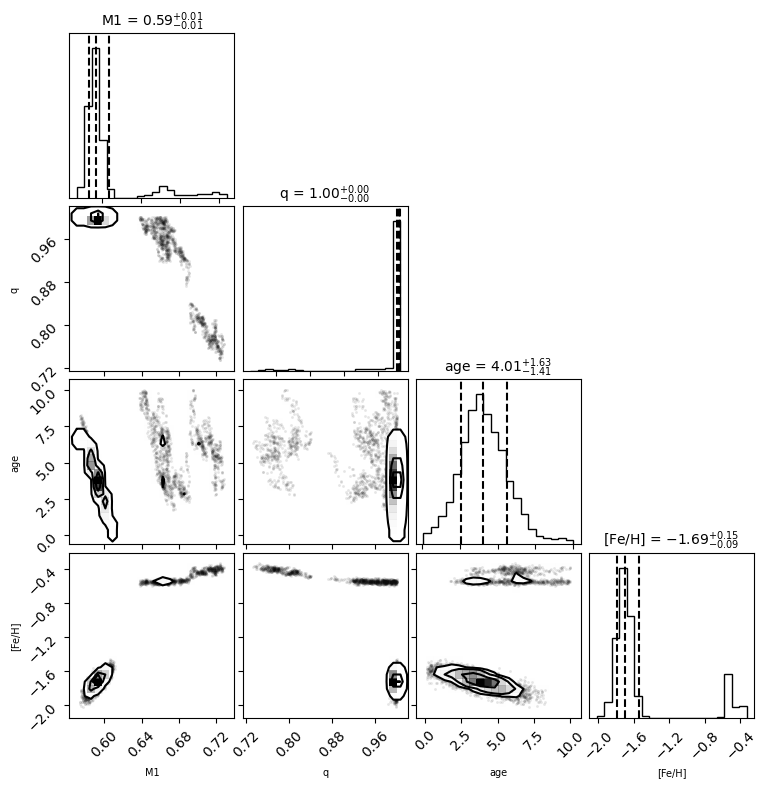

In [29]:
n_dim = parameters[0].shape[1]
fig, _ = plt.subplots(n_dim, n_dim, figsize=(8,8))
fig = corner.corner(parameters[0], labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, fig=fig,
                    title_kwargs={"fontsize":10}, label_kwargs=dict(fontsize=7), truth_color='C0')

In [30]:
import json

final_parameters = {}
for i in range(len(bound_df_cluster)):
    values = np.percentile(parameters[i], 50, axis=0)
    final_parameters[i] = {'mass': values[0],
                            'q': values[1],
                            'age': values[2],
                            'fe_h': values[3]
                            }
    
with open('./data/estimations.json', 'w') as f:
    json.dump(final_parameters, f, indent=4)

In [17]:
import json
with open(f'./data/estimations_{cluster}_uniform.json') as f:
    estimations = json.load(f)

In [18]:
bound_df_cluster['mass'] = np.nan
bound_df_cluster['q'] = np.nan
bound_df_cluster['age'] = np.nan
bound_df_cluster['fe_h'] = np.nan

for i in range(len(bound_df_cluster)):
    bound_df_cluster.loc[i, 'mass'] = estimations[str(i)]['mass']
    bound_df_cluster.loc[i, 'q'] = estimations[str(i)]['q']
    bound_df_cluster.loc[i, 'age'] = estimations[str(i)]['age']
    bound_df_cluster.loc[i, 'fe_h'] = estimations[str(i)]['fe_h']

In [19]:
bound_df_cluster

,source_id,ra,dec,pmra,pmdec,parallax,parallax_corrected,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,cluster,g_mag,bp_mag,rp_mag,mass,q,age,fe_h
0,4039931725653660544,268.282551,-37.110006,3.140380,-5.833935,3.651388,3.617150,13.004601,13.477786,12.371492,NGC_6475,5.816891,6.290076,5.183782,0.759635,0.773225,5.593647,-0.226753
1,4039018512529423360,270.692256,-35.161469,3.545403,-5.120698,3.575582,3.575582,17.964058,19.245052,16.654226,NGC_6475,10.730792,12.011786,9.420960,1.805154,0.869646,9.493229,-1.463789
2,4039009789556712832,270.615784,-35.403758,3.247486,-5.160776,3.469499,3.437812,10.855417,11.159005,10.354898,NGC_6475,3.556751,3.860339,3.056232,0.927925,0.219496,9.420236,-0.480758
3,4039012430851778688,270.453771,-35.336052,3.955242,-6.074262,3.673141,3.629934,13.371992,13.901957,12.675690,NGC_6475,6.197180,6.727145,5.500878,0.828937,0.054607,7.204609,0.385113
4,4040793811722135808,268.455633,-35.071979,2.798568,-4.792476,3.531545,3.531545,18.445030,19.451120,17.014086,NGC_6475,11.184853,12.190943,9.753909,1.626665,0.878357,9.444704,-1.464820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,4043388457118235136,267.896704,-33.452152,3.468674,-5.533250,3.592259,3.561883,10.385437,10.622767,9.989314,NGC_6475,3.162275,3.399605,2.766152,1.182727,0.596134,3.767765,-0.135081
1086,4043392816513324928,267.780259,-33.369144,2.155390,-5.116212,3.629188,3.568023,16.826498,18.205390,15.636375,NGC_6475,9.625545,11.004437,8.435422,0.479477,0.355925,8.845358,0.447874
1087,4043357258503604352,269.208472,-32.688905,2.944836,-5.009764,3.651980,3.614024,6.649078,6.684957,6.534089,NGC_6475,-0.538280,-0.502401,-0.653269,2.727688,0.672080,0.525507,-0.002814
1088,4043399761419023872,268.226090,-33.153245,2.366334,-5.293691,3.621000,3.573355,18.157236,19.878290,16.957027,NGC_6475,10.951378,12.672432,9.751169,0.324753,0.237285,5.299746,0.265454


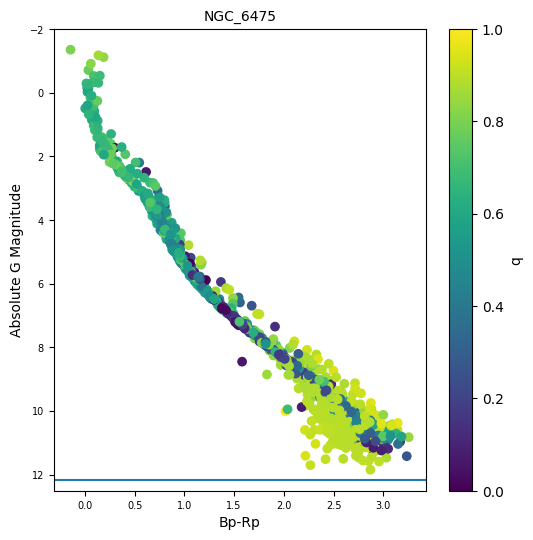

In [24]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title(cluster, fontsize=10)
ax.scatter(bound_df_cluster['bp_mag'] - bound_df_cluster['rp_mag'], bound_df_cluster['g_mag'], marker='o', c=bound_df_cluster['q'])
ax.axhline(max_g_mag_simulated)
ax.invert_yaxis()
ax.set_xlabel('Bp-Rp')
ax.set_ylabel('Absolute G Magnitude')
ax.tick_params(axis='both', which='major', labelsize=7)
fig.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="q")

# Read data from estimations

In [15]:
binaries = pd.read_csv('./data_artem/binaries.csv')
del binaries['Unnamed: 0']
binaries['g_abs'] = binaries['RPmag'] - 5*np.log10(1000*binaries['Dist50']) + 5
binaries

,GaiaEDR3,Gmag,RPmag,BPmag,Plx,Dist50,M1,q_ratio,age,fe_h,log_distance,g_abs
0,3839689084608000384,6.2382,5.9581,6.3554,10.974,0.09114,1.033563,0.623762,7.370112,-2.250378,1.952739,1.159555
1,5870261656933718784,11.1995,10.5217,11.7148,11.055,0.09046,0.573231,0.950858,2.984773,-0.863638,1.956973,5.739417
2,5472035042322559232,8.1138,7.6623,8.3673,10.214,0.09849,1.085973,0.448749,3.447530,-1.912268,2.007660,2.695339
3,346081253464896128,8.8243,8.2894,9.1869,10.171,0.09843,1.097300,0.473487,1.973911,-1.934580,1.994598,3.323763
4,2005707778312337280,10.3786,9.6747,10.9237,13.395,0.07470,0.606492,0.851098,0.507758,-2.028281,1.872658,5.308097
5,4327126469222618112,12.6003,11.6351,13.5525,13.697,0.07305,0.339556,0.807854,0.505116,-1.215874,1.863289,7.316999
6,4485972467412021376,8.2252,7.7437,8.5253,18.786,0.05325,6.973423,0.668826,0.129320,-1.538140,2.224850,4.112102
7,5729803105228876800,14.5245,13.3414,15.8688,12.188,0.08208,0.041714,0.242415,0.231278,-1.463647,1.911670,8.770213
8,2292898390100418048,12.2164,11.2521,13.0985,14.192,0.07047,0.359056,0.908900,0.442354,-1.918948,1.846484,7.012079
9,2897454348851010944,10.8892,10.2238,11.4000,11.575,0.08661,0.592874,0.941906,0.509878,-1.339964,1.937858,5.535960


In [16]:
data_binary

,GaiaEDR3,Gmag,RPmag,BPmag,Plx,Dist50,RUWE,[Fe/H],mass,mass_error,flag,bp_rp,g_abs
0,2875125810310195712,8.3483,7.8431,8.6769,20.194,0.04952,14.26,-0.198054,1.050534,0.039871,1.0,0.8338,4.369197
1,2854954135627103488,8.7198,8.2686,9.0063,11.564,0.08655,4.38,0.117633,1.119408,0.058134,1.0,0.7377,3.582265
2,2880986374788373376,11.7497,10.9730,12.4039,11.104,0.09007,1.23,0.170862,0.696993,0.039649,1.0,1.4309,6.200099
3,2746869015880925696,12.8457,11.8978,13.7273,10.750,0.09306,1.55,-0.557720,0.576496,0.040613,1.0,1.8295,7.053985
4,2772904695310603520,8.5413,7.8083,8.9998,33.259,0.03007,1.61,-0.532630,0.830923,0.038654,1.0,1.1915,5.417633
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20905,2449723662011846528,9.0460,8.5649,9.3120,12.488,0.08012,5.68,-0.864598,1.128512,0.044576,1.0,0.7471,4.046195
20906,2747165574782671872,14.2360,13.1069,15.5405,11.236,0.08901,1.22,-1.563757,0.423861,0.039397,1.0,2.4336,8.359706
20907,2332946559249914240,9.2790,8.8052,9.5798,10.334,0.09678,2.16,-0.362188,1.154735,0.089841,1.0,0.7746,3.876272
20908,2335088098663208320,11.3043,10.4918,12.0154,11.053,0.09047,1.66,-0.290771,0.777653,0.040177,1.0,1.5236,5.709277


In [21]:
data_binary[0:1]

,GaiaEDR3,Gmag,RPmag,BPmag,Plx,Dist50,RUWE,[Fe/H],mass,mass_error,flag,bp_rp,g_abs
0,2875125810310195712,8.3483,7.8431,8.6769,20.194,0.04952,14.26,-0.198054,1.050534,0.039871,1.0,0.8338,4.369197


In [22]:
data_binary[1:2]

,GaiaEDR3,Gmag,RPmag,BPmag,Plx,Dist50,RUWE,[Fe/H],mass,mass_error,flag,bp_rp,g_abs
1,2854954135627103488,8.7198,8.2686,9.0063,11.564,0.08655,4.38,0.117633,1.119408,0.058134,1.0,0.7377,3.582265


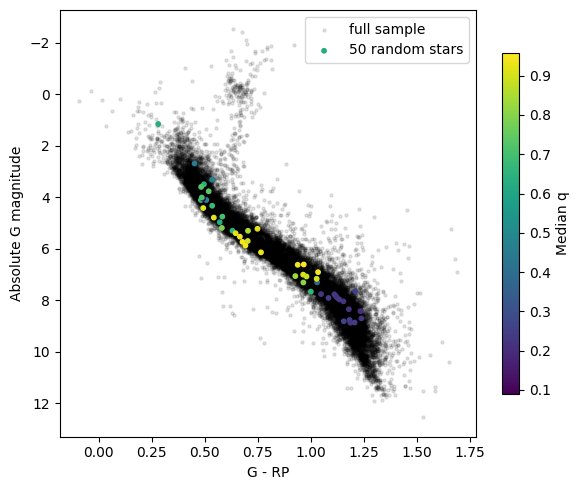

In [17]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(data_binary['Gmag'] - data_binary['RPmag'], data_binary['g_abs'], s=5, c='k', alpha=0.1, label='full sample')
plot = ax.scatter(binaries['Gmag'] - binaries['RPmag'], binaries['g_abs'], s=10, alpha=1, c=binaries['q_ratio'], label='%s random stars'%len(binaries))
cbar = fig.colorbar(plot, label='Median q', shrink=0.8)
ax.legend()
ax.invert_yaxis()
ax.set_xlabel('G - RP')
ax.set_ylabel('Absolute G magnitude')
plt.tight_layout()

# Read data for a cluster

tensor([[  2.8389,   9.4262,   8.7873, 186.0027],
        [  3.6939,  10.3606,   9.5485, 185.0563],
        [  3.9296,  10.5895,   9.7409, 183.6977],
        [  4.1376,  10.7494,   9.8943, 179.3638],
        [  5.0278,  11.8319,  10.7596, 185.7776],
        [  5.9467,  12.8715,  11.5876, 187.0194],
        [  6.0186,  13.0088,  11.6211, 186.9411],
        [  7.1049,  14.1968,  12.6188, 186.3743],
        [  7.3619,  14.3675,  12.7251, 176.2112],
        [  7.3302,  14.5300,  12.8434, 190.2076]], dtype=torch.float64)


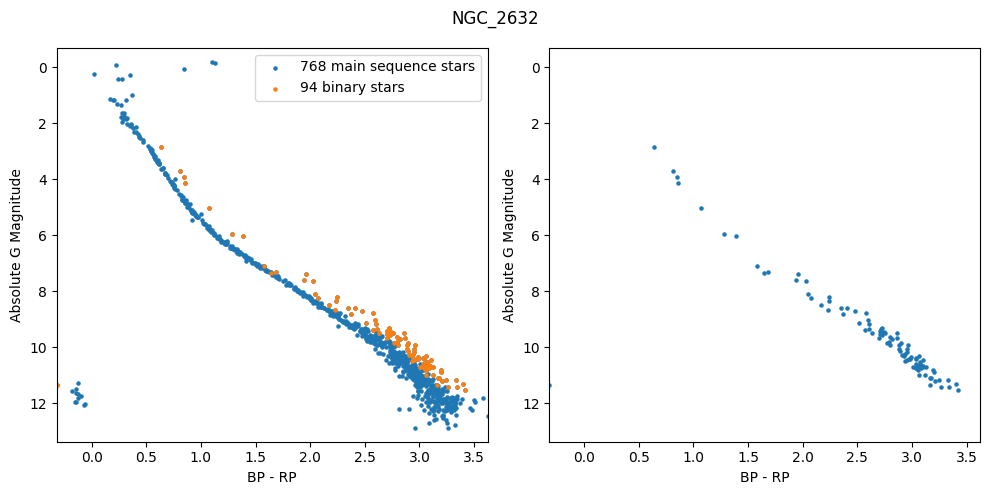

In [35]:
cluster = 'NGC_2632'#'NGC_2682'
df = pd.read_csv('../data_masses/{}.csv'.format(cluster))
#df = pd.read_csv('/home/steven/Dropbox/data_open_clusters/{}.csv'.format(cluster))
df['log_dist'] = np.log10(df['distance'])
df['g_mag'] = df['phot_g_mean_mag'] - 5*df['log_dist'] + 5
condition = (df['binary'] == True)

df_binary = df[condition]
observation_per_cluster = df_binary[['g_mag','phot_bp_mean_mag','phot_rp_mean_mag','distance']].to_numpy()
observation_per_cluster = torch.from_numpy(observation_per_cluster)
print(observation_per_cluster[:10,:])

d_edges = 0.5
custom_xlim = (df['bp_rp'].min(), df['bp_rp'].max())
custom_ylim = (df['g_mag'].min()-d_edges, df['g_mag'].max()+d_edges)

fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle(cluster)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

ax[0].scatter(df['bp_rp'], df['g_mag'], s=5, label='%s main sequence stars'%(len(df)-len(df[condition])))
#ax[0].scatter(df['bp_rp'][condition], df['g_mag'][condition], s=5, label='%s binary stars'%(len(df[condition])))
ax[0].scatter(observation_per_cluster[:,1].numpy() - observation_per_cluster[:,2].numpy(), observation_per_cluster[:,0].numpy(), \
              s=5, label='%s binary stars'%(len(df[condition])))
ax[0].set_xlabel('BP - RP')
ax[0].set_ylabel('Absolute G Magnitude')
ax[0].legend()
ax[0].invert_yaxis()

ax[1].scatter(df['bp_rp'][condition], df['g_mag'][condition], s=5)
ax[1].set_xlabel('BP - RP')
ax[1].set_ylabel('Absolute G Magnitude')
ax[1].invert_yaxis()

fig.tight_layout()

In [24]:
observation_per_cluster[:-7,:]#.shape

tensor([[  2.8389,   9.4262,   8.7873, 186.0027],
        [  3.6939,  10.3606,   9.5485, 185.0563],
        [  3.9296,  10.5895,   9.7409, 183.6977],
        [  4.1376,  10.7494,   9.8943, 179.3638],
        [  5.0278,  11.8319,  10.7596, 185.7776],
        [  5.9467,  12.8715,  11.5876, 187.0194],
        [  6.0186,  13.0088,  11.6211, 186.9411],
        [  7.1049,  14.1968,  12.6188, 186.3743],
        [  7.3619,  14.3675,  12.7251, 176.2112],
        [  7.3302,  14.5300,  12.8434, 190.2076],
        [  7.3712,  14.7082,  12.7491, 187.0150],
        [  7.6476,  15.0108,  12.9806, 185.5935],
        [  7.5921,  14.9906,  13.0489, 193.5494],
        [  8.1020,  15.4437,  13.3959, 182.2865],
        [  8.2114,  15.7336,  13.4915, 186.4999],
        [  8.2444,  15.6694,  13.5943, 188.2694],
        [  8.3555,  15.8241,  13.5854, 182.1640],
        [  8.5079,  15.9708,  13.7991, 186.0354],
        [  8.5907,  16.2007,  13.8512, 187.3591],
        [  8.6809,  16.1324,  13.9022, 181.3603],


# Do sampling for each one.

In [12]:
num_injections = len(observation_per_cluster)
num_injections, num_samples

(94, 2000)

In [15]:
#dir(posterior)

In [16]:
#posterior.sample.__doc__

In [28]:
observation_per_cluster[2,:]

tensor([  2.3346,  10.7600,  10.2512, 444.2360], dtype=torch.float64)

In [29]:
L = 5 # number of parameters
all_samples = np.empty((num_injections, num_samples, L))

for i in tqdm(range(len(observation_per_cluster))):
    obs = observation_per_cluster[i,:]
    all_samples[i] = posterior.sample((num_samples,), x=obs, show_progress_bars=False) # sample_with='mcmc'

 22%|██▏       | 26/117 [00:03<00:20,  4.41it/s]WARNING:root:Only 0.550% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    1989 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 25%|██▍       | 29/117 [00:07<00:57,  1.54it/s]WARNING:root:Only 0.700% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    1986 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 26%|██▌       | 30/117 [00:10<01:55,  1.32s/it]WARNING:root:Only 0.700% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    1986 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 26%|██▋       | 31/117 [00:13<02:29,  1.74

In [ ]:
# #_, L = sbi_prior.sample((1, )).shape
# L = 5 # number of parameters

# all_samples = np.empty((num_injections, num_samples, L))

# for i, obs in enumerate(tqdm(observation_per_cluster)):
#     all_samples[i] = posterior.sample((num_samples,), x=obs, show_progress_bars=False) # sample_with='mcmc'

In [ ]:
# Let's see where the truth was as a percentile in each injection.

In [30]:
all_samples.shape, len(all_samples)

((117, 2000, 5), 117)

In [31]:
#100*3000 - 160000 # empanadas
all_samples[0]

array([[ 1.71687019,  0.20461966,  1.22802162, -0.52657241,  2.64184141],
       [ 1.86904979,  0.12335108,  0.89641601, -0.64948767,  2.64153886],
       [ 1.59936488,  0.46477675,  1.30501401, -1.10429144,  2.64164591],
       ...,
       [ 1.56489849,  0.89983886,  1.27440882, -0.97147095,  2.64160442],
       [ 2.32391453,  0.33412316,  0.44948256,  0.23930401,  2.64194512],
       [ 2.28023648,  0.38174421,  0.47567874,  0.22642089,  2.64161205]])

# Get params from sampling per star

In [53]:
estimated_params = np.zeros((len(all_samples), 5)) 
#errors_up = np.zeros_like(estimated_params) 
#errors_down = np.zeros((len(all_samples), 4)) 

for i in range(len(all_samples)):
    params = np.percentile(all_samples[i], 50, axis=0)
    for j in range(len(params)):
        estimated_params[i,j] = params[j]

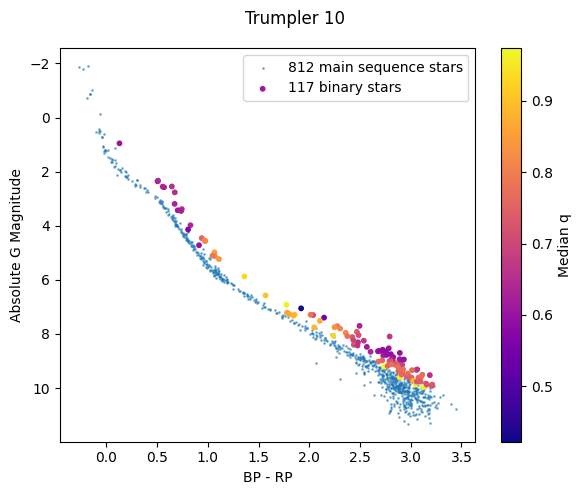

In [54]:
fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(cluster. replace('_',' '))
ax.scatter(df['bp_rp'], df['g_mag'], s=1, c='C0', alpha=0.5, label='%s main sequence stars'%(len(df)-len(df[condition])))
sc = ax.scatter(df['bp_rp'][condition], df['g_mag'][condition], s=10, label='%s binary stars'%(len(df[condition])), c=estimated_params[:,1],\
                cmap='plasma')
ax.set_xlabel('BP - RP')
ax.set_ylabel('Absolute G Magnitude')
ax.invert_yaxis()
ax.legend()
fig.colorbar(sc, label='Median q', location='right', ax=ax)
fig.tight_layout()
fig.savefig('./images/binary_test.png', bbox_inches='tight')

In [65]:
estimated_params

array([[ 1.96594959e+00,  6.06719524e-01,  7.49792039e-01,
        -2.64571697e-01,  2.64166582e+00],
       [ 1.38461351e+00,  6.15859956e-01,  2.12876236e+00,
        -2.02687651e-01,  2.62659824e+00],
       [ 1.39850068e+00,  6.38682812e-01,  2.11362314e+00,
        -1.74149796e-01,  2.64793015e+00],
       [ 1.34532237e+00,  6.50905758e-01,  3.08234727e+00,
        -6.73831347e-03,  2.62092102e+00],
       [ 1.33846194e+00,  6.45657718e-01,  2.44573975e+00,
        -1.34777054e-01,  2.63187206e+00],
       [ 1.33711576e+00,  6.24984413e-01,  2.61611283e+00,
        -1.17866553e-01,  2.63852453e+00],
       [ 1.30397105e+00,  6.51654303e-01,  3.50954139e+00,
         2.93800021e-02,  2.61598551e+00],
       [ 1.19018745e+00,  6.33120090e-01,  3.94148743e+00,
        -1.37960995e-02,  2.63583601e+00],
       [ 1.17384553e+00,  6.51273251e-01,  4.83569884e+00,
         1.16820421e-01,  2.63911724e+00],
       [ 1.14623135e+00,  6.09878033e-01,  4.53937531e+00,
         2.24275747e-03

In [66]:
df_binary

,Unnamed: 0,source_id,ra,ra_error,dec,dec_error,l,b,parallax,parallax_error,...,distance,x,y,z,g_mag,mass_predicted,binary,log_dist,M1,q_ratio
16,16,5524172955997468672,131.982411,0.014929,-42.589472,0.016745,262.902515,0.590560,2.288712,0.018811,...,439.263751,-54.271586,-435.874684,4.527505,0.953672,0.398852,True,2.642725,0.986230,0.599276
50,50,5330276863582453632,135.705815,0.010570,-46.206029,0.011268,267.380575,0.282447,2.376348,0.013569,...,422.971461,-19.330223,-422.524380,2.085078,2.357265,0.237526,True,2.626311,0.587567,0.590443
54,54,5524153542751548800,132.421855,0.012390,-42.443742,0.013544,262.993803,0.933809,2.268921,0.015726,...,444.236000,-54.179192,-440.860322,7.239855,2.334613,0.227848,True,2.647614,0.613076,0.601119
55,55,5523934911734512384,132.585425,0.013013,-42.974942,0.014140,263.480942,0.690166,2.408563,0.016728,...,417.513000,-47.398307,-414.783334,5.029098,2.548037,0.218834,True,2.620670,0.589817,0.594142
59,59,5523369243062322176,129.809169,0.008261,-43.035190,0.009541,262.266105,-0.937554,2.348214,0.010609,...,428.155085,-57.610098,-424.203692,-7.005770,2.554124,0.211925,True,2.631601,0.562983,0.617008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,613,5529511875230699392,128.206129,0.077031,-38.834348,0.092764,258.181794,0.621624,2.291340,0.104206,...,436.425879,-89.377801,-427.149549,4.734857,9.747679,-0.273360,True,2.639910,0.000000,0.000000
620,620,5525383483944324992,132.227254,0.063275,-41.255249,0.069685,261.980804,1.572450,2.434311,0.081521,...,417.207522,-58.180514,-412.972244,11.448580,9.872139,-0.274580,True,2.620352,0.000000,0.000000
641,641,5523937175177409408,132.663365,0.082287,-42.863544,0.091023,263.431103,0.804986,2.444204,0.106002,...,409.131234,-46.799082,-406.405184,5.747960,9.967445,-0.277009,True,2.611863,0.000000,0.000000
646,646,5524185188069302272,131.787996,0.076497,-42.513600,0.096093,262.753524,0.526745,2.361597,0.099826,...,429.921417,-54.227067,-426.469493,3.952397,9.874723,-0.277697,True,2.633389,0.000000,0.000000


In [69]:
df_binary['M1'] = 0
df_binary['q_ratio'] = 0
df_binary.reset_index(inplace=True)

for i in range(len(df_binary)):
    df_binary['M1'][i] = estimated_params[i,0]
    df_binary['q_ratio'][i] = estimated_params[i,1]

In [76]:
df_binary.to_csv('../data_masses/binaries/{}.csv'.format(cluster))

In [74]:
print(df_binary['q_ratio'].min(), df_binary['q_ratio'].max())
print(df_binary['M1'].min(), df_binary['M1'].max())

0.4224949926137924 0.9737186133861542
0.39103399217128754 1.9659495949745178


In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle(cluster)

for i in range(len(estimated_params[:,1])):
    if estimated_params[:,1][i] > 0.5:
        color_ = df['phot_bp_mean_mag'][i] - df['phot_rp_mean_mag'][i]
        ax.scatter(color_, df['phot_g_mean_mag'][i], cmap='viridis', c=estimated_params[:,1][i], s=5)

#sc = ax.scatter(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'], df['phot_g_mean_mag'], cmap='viridis', c=estimated_params[:,1], s=5)
ax.set_xlabel('BP - RP')
ax.set_ylabel('G')
ax.invert_yaxis()
#fig.colorbar(sc, label='Median q', location='right', ax=ax) 
fig.tight_layout()

In [ ]:
from scipy.stats import percentileofscore as pos
true_theta = np.array(true_theta)

percentiles = np.empty((num_injections, L))
for i, this_theta in enumerate(tqdm(np.array(true_theta))):
    for j, t in enumerate(this_theta):
        percentiles[i, j] = pos(all_samples[i, :, j], t)

In [ ]:
fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.flat):
    ax.hist(percentiles[:, i])
    ax.set_xlabel(labels[i])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    lower, mean, upper = np.percentile(all_samples[:, :, i], [16, 50, 84], axis=1)
    yerr_pos = upper - mean
    yerr_neg = mean - lower
    ax.errorbar(
        true_theta[:, i],
        mean,
        yerr=(yerr_neg, yerr_pos),
        fmt='o'
    )
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", ls=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_title(labels[i])
    ax.set_xlabel(f"injected")
    ax.set_ylabel(f"recovered")

In [ ]:
## TODO: Check that this is the right thing to be doing here!
fig, ax = plt.subplots(figsize=(6, 6))

for i, label in enumerate(labels):
    x = percentiles.T[i]
    y = true_theta.T[i]
    ax.plot(
        np.cumsum(x)/np.sum(x),
        np.cumsum(y)/np.sum(y),
        label=label
    )
limits = [0, 1]
ax.plot(limits, limits, c="#666666", zorder=-1, ls=":")
ax.legend()
ax.set_xlim(limits)
ax.set_ylim(limits)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

from matplotlib.colors import LogNorm 
def plot_binned_statistic(x, y, z, bins=100, function=np.nanmedian,
                          xlabel=None, ylabel=None, zlabel=None,
                          ax=None, colorbar=False, figsize=(8, 8),
                          vmin=None, vmax=None, min_entries_per_bin=None,
                          subsample=None, mask=None, full_output=False, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
    
    finite = np.isfinite(x * y * z)
    if mask is not None:
        finite *= mask
    if subsample is not None:
        idx = np.where(finite)[0]
        if subsample < 1:
            subsample *= idx.size
        if int(subsample) > idx.size:
            finite = idx
        else:
            finite = np.random.choice(idx, int(subsample), replace=False)
    
    H, xedges, yedges, binnumber = binned_statistic_2d(
        x[finite], y[finite], z[finite],
        statistic=function, bins=bins)

    if min_entries_per_bin is not None:
        if function != "count":
            H_count, xedges, yedges, binnumber = binned_statistic_2d(
                x[finite], y[finite], z[finite],
                statistic="count", bins=bins)

        else:
            H_count = H

        H[H_count < min_entries_per_bin] = np.nan


    if (vmin is None or vmax is None) and "norm" not in kwargs:
        vmin_default, med, vmax_default = np.nanpercentile(H, kwargs.pop("norm_percentiles", [5, 50, 95]))
        if vmin is None:
            vmin = vmin_default
        if vmax is None:
            vmax = vmax_default
    
    imshow_kwds = dict(
        vmin=vmin, vmax=vmax,
        aspect=np.ptp(xedges)/np.ptp(yedges), 
        extent=(xedges[0], xedges[-1], yedges[-1], yedges[0]),
        cmap="inferno",
        interpolation="bilinear")
    imshow_kwds.update(kwargs)
    
    image = ax.imshow(H.T, **imshow_kwds)
    if colorbar:
        cbar = plt.colorbar(image, ax=ax)
        if zlabel is not None:
            cbar.set_label(zlabel)

    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    #fig.tight_layout()

    return (fig, image) if full_output else fig

In [ ]:
c

In [ ]:
# Plot the training set and the injection set in data coords
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# b, r, g
c_index = 1 # q
c = x.T[c_index]
#vmin, vmax = (min(c), max(c))
plot_binned_statistic(
    np.array(x.T[0] - x.T[1]),
    np.array(x.T[2]),
    np.array(x.T[2]),
    norm=LogNorm(),
    function="count",
    min_entries_per_bin=1,
    interpolation="nearest",
    bins=200,
    ax=axes[0]
)

axes[1].scatter(
    true_obs.T[0] - true_obs.T[1],
    true_obs.T[2],
)
for ax in axes:
    ax.set_xlabel("BP-RP")
    ax.set_ylabel("M_G")
axes[1].set_xlim(axes[0].get_xlim())
axes[1].set_ylim(axes[0].get_ylim())

axes[0].set_title("Training set")
axes[1].set_title("Injection set")

In [ ]:
delta_q = np.abs(true_theta[:, 1] - np.mean(all_samples[:, :, 1], axis=1))
bad_index = np.argmax(delta_q)
bad_theta = true_theta[bad_index]
print(bad_theta)

In [ ]:
print(all_samples.shape)
fig = analysis.pairplot(
    all_samples[bad_index], 
    points=bad_theta,
    labels=labels,
    figsize=(10, 10),
    points_colors=["tab:red"]
)

In [ ]:
delta_q = np.abs(true_theta[:, 1] - np.mean(all_samples[:, :, 1], axis=1))
good_index = np.argmin(delta_q)
good_theta = true_theta[good_index]
print(good_theta)

In [ ]:
fig = analysis.pairplot(
    all_samples[good_index], 
    points=good_theta,
    labels=labels,
    figsize=(10, 10),
    points_colors=["tab:red"]
)

# Plot

In [62]:
import numpy as np
import astropy.coordinates as apycoords
import astropy.units as u
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
import pandas as pd

# Our paper

In [35]:
catalog = 'J/A+A/689/A18/members' #Exploring
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
df = query.to_pandas()
df = df.fillna(0)
df['d'] = 1000. / df['Plx']
df

,Cluster,GaiaDR3,RA_ICRS,DE_ICRS,pmRA,pmDE,Plx,PlxCorr,_RA.icrs,_DE.icrs,d
0,ASCC_10,125596289824676864,50.703770,33.515756,-2.054702,-1.767013,1.324568,1.291788,50.703781,33.515764,754.963390
1,ASCC_10,125638758461159040,50.348322,33.726894,-1.167929,-2.679550,1.311128,1.269733,50.348328,33.726905,762.701993
2,ASCC_10,125646248884232448,50.763114,33.678626,-1.895948,-1.781295,1.347874,1.306567,50.763125,33.678634,741.909063
3,ASCC_10,125646558121874176,50.753848,33.699988,-1.707604,-3.275335,1.340151,1.307543,50.753857,33.700003,746.184712
4,ASCC_10,125673736674769792,50.713269,34.083176,-2.139180,-3.446868,1.348603,1.306908,50.713280,34.083191,741.507901
...,...,...,...,...,...,...,...,...,...,...,...
87703,vdBergh_83,2918885307946726912,101.137289,-27.528837,-3.010456,4.709788,1.067329,1.029433,101.137305,-27.528858,936.918452
87704,vdBergh_83,2918893382485209600,101.244716,-27.429275,-3.294288,4.128923,1.080757,1.052912,101.244733,-27.429293,925.277698
87705,vdBergh_83,2920028520863715328,101.254002,-27.043379,-1.764080,3.952414,0.931194,0.902875,101.254011,-27.043397,1073.890216
87706,vdBergh_83,2920038008450358272,101.384512,-26.864962,-1.764122,4.153722,0.915774,0.876716,101.384521,-26.864980,1091.971968


In [67]:
catalog = 'J/A+A/689/A18/clusters' #Exploring
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
df = query.to_pandas()
df = df.rename(columns={'Cluster':'cluster'})
our = df.fillna(0)
our = our[['cluster','logAge']]
our

,cluster,logAge
0,ASCC_10,8.565278
1,ASCC_101,8.441943
2,ASCC_105,7.891654
3,ASCC_107,7.196614
4,ASCC_11,8.795452
...,...,...
365,UPK_93,8.830048
366,UPK_94,7.838441
367,UPK_99,8.129055
368,vdBergh_80,6.995075


# Hunt and Reffer

In [28]:
# catalog = 'J/A+A/673/A114/clusters' #Exploring
# query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
# df = query.to_pandas()
# hunt = df.fillna(0)
# hunt

In [68]:
from astropy.table import Table
dat = Table.read('/Users/steven/Documents/hunt_clusters.fits', format='fits')
df = dat.to_pandas()
df['Name'] = df['Name'].str.decode('utf-8')
df['Name'] = df['Name'].str.replace(" ", "")
df = df.rename(columns={'Name':'cluster','logAge50':'logAge'})
hunt = df[['cluster','logAge']]
hunt

,cluster,logAge
0,1636-283,8.487957
1,ADS_16795,7.755186
2,AH03_J0748+26.9,8.061740
3,ASCC_5,7.325891
4,ASCC_6,7.961030
...,...,...
7162,vdBergh_85,7.653578
7163,vdBergh_92,6.643097
7164,vdBergh_113,7.541749
7165,vdBergh_130,6.661336


In [74]:
# c_our = our[our['cluster'].isin(hunt['cluster'].to_list())]
# c_our

In [73]:
# c_hunt = hunt[hunt['cluster'].isin(our['cluster'].to_list())].reset_index()
# del c_hunt['index']
# c_hunt

In [70]:
#common_clusters = pd.merge(c_our, c_hunt, on='cluster')
common_clusters = pd.merge(our, hunt, on='cluster')
common_clusters = common_clusters.rename(columns={'logAge_x':'logAge_our','logAge_y':'logAge_hunt'})
common_clusters

,cluster,logAge_our,logAge_hunt
0,ASCC_101,8.441943,8.276054
1,ASCC_105,7.891654,7.970471
2,ASCC_107,7.196614,7.385967
3,ASCC_11,8.795452,8.369570
4,ASCC_111,8.683384,7.895664
...,...,...,...
309,UPK_93,8.830048,8.750780
310,UPK_94,7.838441,8.434775
311,UPK_99,8.129055,8.334580
312,vdBergh_80,6.995075,6.750538


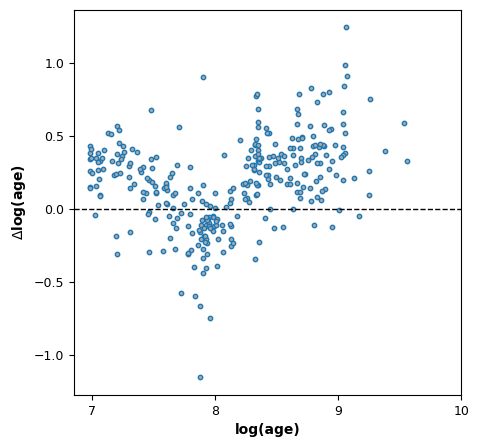

In [72]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(common_clusters['logAge_our'], common_clusters['logAge_our'] - common_clusters['logAge_hunt'], marker='o', s=10, \
           color="darkgrey", ec="C0", lw=1.0)
ax.axhline(0, ls='--', lw=1., color='k')
ax.set_xticks([7,8,9,10])
ax.set_xlabel("log(age)", fontsize=10, weight='bold')
ax.set_ylabel("$\Delta$log(age)", fontsize=10, weight='bold')
ax.tick_params(axis='both', labelsize=9)
ax.set_aspect('auto', adjustable='box')

In [32]:
open_cluster = df[df['Cluster']=='FSR_0551']
open_cluster

,Cluster,GaiaDR3,RA_ICRS,DE_ICRS,pmRA,pmDE,Plx,PlxCorr,_RA.icrs,_DE.icrs,d
18179,FSR_0551,519062263906703616,25.720121,65.280251,0.145523,-1.496366,1.067566,1.035993,25.720120,65.280258,936.710660
18180,FSR_0551,513105212990840704,25.361267,65.311283,-0.422009,-1.303010,1.048930,1.013257,25.361272,65.311289,953.352813
18181,FSR_0551,513111500823058560,24.654965,65.187287,-1.064354,-1.387709,1.081498,1.050597,24.654976,65.187293,924.643539
18182,FSR_0551,513116895301688704,24.277254,65.311697,-0.229565,-1.651650,1.059241,1.026535,24.277256,65.311705,944.072507
18183,FSR_0551,513117445057496192,24.302683,65.356300,0.289756,-1.394796,1.036253,1.004739,24.302680,65.356306,965.015393
...,...,...,...,...,...,...,...,...,...,...,...
18358,FSR_0551,512944031457254144,23.352079,64.348435,0.243551,-1.589755,1.079553,1.047674,23.352077,64.348442,926.309232
18359,FSR_0551,513171080606619648,23.262696,64.820356,-0.133922,-1.528152,1.027586,0.995551,23.262697,64.820363,973.154350
18360,FSR_0551,512982033328572672,24.127515,64.736298,-0.957688,-2.063772,1.075505,1.043573,24.127525,64.736307,929.796045
18361,FSR_0551,513210285068834688,22.409533,64.886530,-0.092947,-1.431257,1.025125,0.994247,22.409534,64.886537,975.490543


184


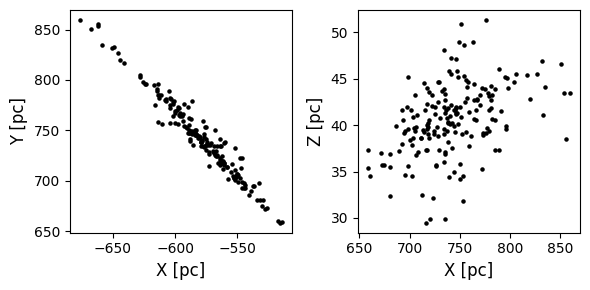

In [42]:
open_cluster = df[df['Cluster']=='FSR_0551']
print(len(open_cluster))

c = apycoords.SkyCoord(ra=open_cluster['RA_ICRS'].values*u.deg, dec=open_cluster['DE_ICRS'].values*u.deg, \
                       distance=open_cluster['d'].values *u.pc, frame='icrs')

fig, ax = plt.subplots(1,2, figsize=(6,3))

ax[0].scatter(c.galactic.cartesian.x, c.galactic.cartesian.y, s=5, marker='o', color='k')
ax[0].set_xlabel('X [pc]', fontsize=12)
ax[0].set_ylabel('Y [pc]', fontsize=12)

ax[1].scatter(c.galactic.cartesian.y, c.galactic.cartesian.z, s=5, marker='o', color='k')
ax[1].set_xlabel('X [pc]', fontsize=12)
ax[1].set_ylabel('Z [pc]', fontsize=12)

plt.tight_layout()
plt.show()

939.3254563546716


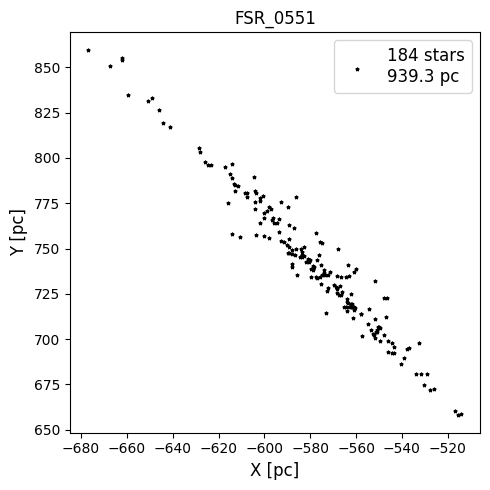

In [55]:
fig, ax = plt.subplots(figsize=(5,5))
print(np.median(open_cluster['d']))
ax.set_title('FSR_0551')
ax.scatter(c.galactic.cartesian.x, c.galactic.cartesian.y, s=5, marker='*', color='k', \
           label='{} stars\n{:.1f} pc'.format(len(open_cluster),np.median(open_cluster['d'])))
ax.set_xlabel('X [pc]', fontsize=12)
ax.set_ylabel('Y [pc]', fontsize=12)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Alfonso paper 1 members

In [75]:
catalog = 'J/A+A/677/A163/members'
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
alfonso_2023 = query.to_pandas()
#df = df.rename(columns={'Cluster':'cluster'})
#our = df.fillna(0)
#our = our[['cluster','logAge']]
alfonso_2023

,GaiaDR3,RA_ICRS,DE_ICRS,Plx,pmRA,pmDE,Cluster,_RA.icrs,_DE.icrs
0,63449521800719488,55.773982,21.030220,7.661184,19.368667,-46.283156,Pleiades,55.773890,21.030425
1,63502259702709888,56.383383,21.246480,7.748071,20.652807,-47.762058,Pleiades,56.383284,21.246693
2,63507860340462208,56.593062,21.088765,7.589614,20.472016,-46.552291,Pleiades,56.592964,21.088972
3,63527827643105408,56.532550,21.345159,7.234548,19.009062,-45.063595,Pleiades,56.532459,21.345359
4,65588484235454592,58.268967,22.801153,7.293433,19.036700,-45.560948,Pleiades,58.268875,22.801355
...,...,...,...,...,...,...,...,...,...
2185,2334037755821523968,359.253456,-27.923260,4.321179,18.987411,1.910564,Blanco_1,359.253361,-27.923269
2186,2334138636012819328,359.363457,-27.693084,4.125127,18.486758,2.119758,Blanco_1,359.363364,-27.693094
2187,2334148870920034432,359.136106,-27.759816,4.270982,19.070604,1.931769,Blanco_1,359.136011,-27.759825
2188,2334177599956226688,359.945951,-27.328056,4.239831,18.613021,1.761267,Blanco_1,359.945858,-27.328064


In [89]:
catalog = 'J/A+A/689/A18/clusters'
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
alfonso_2024 = query.to_pandas()
alfonso_2024 = alfonso_2024[alfonso_2024['Cluster'].isin(['Melotte_22','NGC_2632','Blanco_1'])]
alfonso_2024 = alfonso_2024[['Cluster','Nstars']]
#df = df.rename(columns={'Cluster':'cluster'})
#our = df.fillna(0)
#our = our[['cluster','logAge']]
alfonso_2024

,Cluster,Nstars
56,Blanco_1,579
110,Melotte_22,1130
143,NGC_2632,862


# Cantag-Gaudin members

In [90]:
catalog = 'J/A+A/640/A1/table1' #Portrait Galactic disc cantat-gaudin-2020
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
cg_2020 = query.to_pandas()

cg_2020 = cg_2020.rename(columns={'Cluster':'cluster','RA_ICRS': 'ra','DE_ICRS': 'dec', 'pmRA_':'pmra','pmDE':'pmdec',\
                        'plx':'parallax','nbstars07':'n_stars','AgeNN':'logAge','AVNN':'av','DMNN':'m_M'})
cg_2020 = cg_2020[(cg_2020.Flag != 'notEnoughStars') & (cg_2020.Flag != 'tooRed')].reset_index(drop=True) 
cg_2020 = cg_2020[['cluster','ra','dec','pmra','pmdec','n_stars','parallax','logAge','av','m_M']]
cg_2020 = cg_2020.loc[~cg_2020['cluster'].isin(['Melotte_25','Melotte_111'])] # remove hyades and coma clusters
cg_2020 = cg_2020[cg_2020['cluster'].isin(['Melotte_22','NGC_2632','Blanco_1'])]
cg_2020 = cg_2020[['cluster','n_stars']]
cg_2020

,cluster,n_stars
201,Blanco_1,380
666,Melotte_22,952
802,NGC_2632,685


# Hunt

In [93]:
catalog = 'J/A+A/673/A114/clusters' 
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
hunt_2023 = query.to_pandas()
hunt_2023 = hunt_2023[hunt_2023['Name'].isin(['Melotte_22','NGC_2632','Blanco_1'])]
hunt_2023 = hunt_2023[['Name','N']]
hunt_2023

,Name,N
281,Blanco_1,841
4423,Melotte_22,1721
4598,NGC_2632,1314


In [94]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl

In [ ]:
vegetables = ["AF2023", "CG2020", "AF2024", "Hunt2023"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])